In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip uninstall braindecode

In [ ]:
!pip install braindecode==0.4.85
!pip install eeglib

     |████████████████████████████████| 324 kB 4.4 MB/s 
     |████████████████████████████████| 7.4 MB 20.0 MB/s 
  Created wheel for braindecode: filename=Braindecode-0.4.85-py3-none-any.whl size=71094 sha256=7abd09da2fcf5921a0d40e33592b49752b9712fb2b3270de15e778f50441d24b
  Stored in directory: /root/.cache/pip/wheels/eb/67/4c/81ad85409f913dd7e3ebb4fb5896839680c5627c04d91e3b78
Successfully built braindecode
     |████████████████████████████████| 1.3 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyedflib: filename=pyEDFlib-0.1.22-cp37-cp37m-linux_x86_64.whl size=1520587 sha256=d02573cbf66d99e0bff932ce236e23181feb2ae2c1c2ffd9311ab8fa519b2323
  Stored in directory: /root/.cache/pip/wheels/14/80/1f/e0e403cc35286c74f1d29f55bb5e304d030fb2f560ba7c979f
Successfully built pyedflib


Creating RawArray with float64 data, n_channels=128, n_times=1225545
    Range : 0 ... 1225544 =      0.000 ...  2451.088 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T


Using matplotlib as 2D backend.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


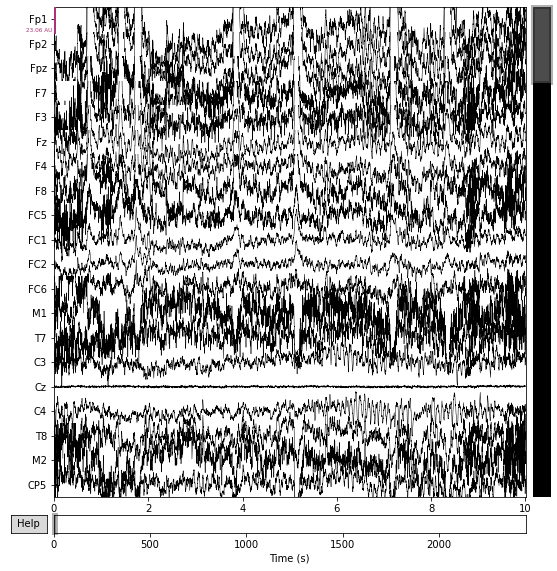

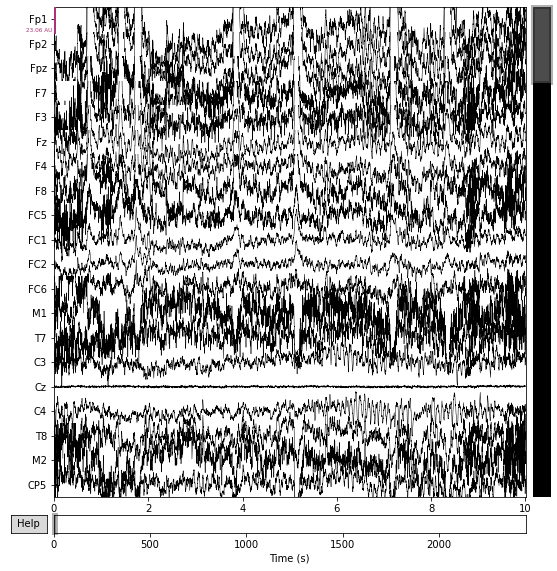

In [ ]:
#读取test1.mat文件用mne
import mne
from braindecode.datasets.bbci import  BBCIDataset
cnt1 = BBCIDataset(filename='/content/drive/MyDrive/EEG-dataset/high-gamma-dataset/a1.mat', load_sensor_names=None).load()
cnt1.plot()

Creating RawArray with float64 data, n_channels=3, n_times=1225545
    Range : 0 ... 1225544 =      0.000 ...  2451.088 secs
Ready.
<RawArray | 4 x 1225545 (2451.1 s), ~37.4 MB, data loaded>


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


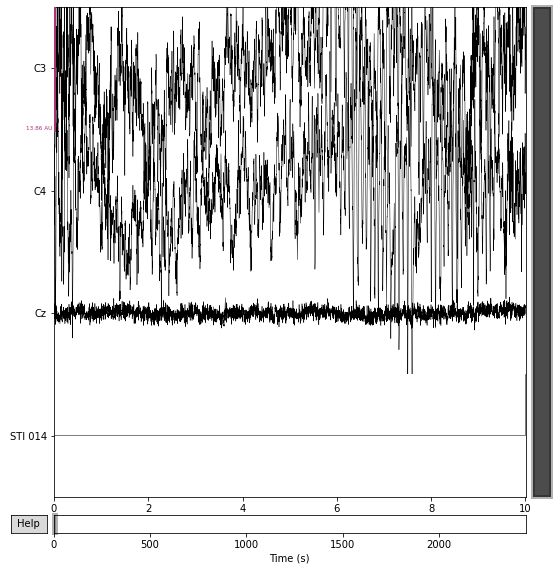

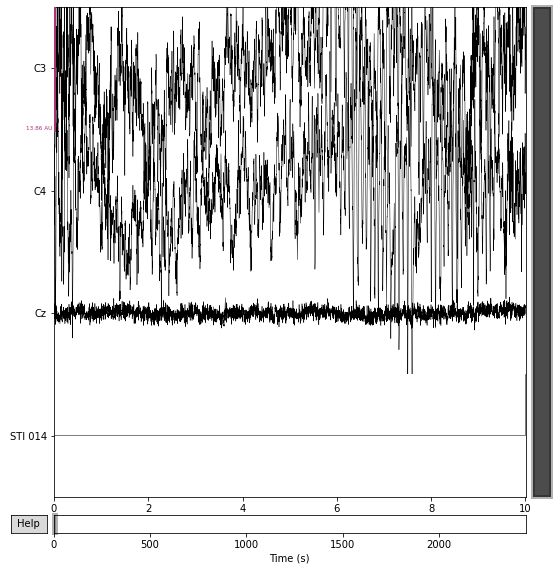

In [ ]:
cnt = BBCIDataset(filename='/content/drive/MyDrive/EEG-dataset/high-gamma-dataset/a1.mat', load_sensor_names=['C3', 'C4', 'Cz']).load()
print(cnt)
cnt.plot()

In [ ]:
import logging
import sys
import os.path
from collections import OrderedDict
import numpy as np

from braindecode.datasets.bbci import  BBCIDataset
from braindecode.datautil.signalproc import highpass_cnt
from braindecode.datautil.trial_segment import create_signal_target_from_raw_mne
from braindecode.mne_ext.signalproc import mne_apply, resample_cnt
from braindecode.datautil.signalproc import exponential_running_standardize

def load_bbci_data(filename, low_cut_hz):
    load_sensor_names = ['C3', 'C4', 'Cz']
    loader = BBCIDataset(filename, load_sensor_names=load_sensor_names)

    cnt = loader.load()

    # Cleaning: First find all trials that have absolute microvolt values
    # larger than +- 800 inside them and remember them for removal later

    marker_def = OrderedDict([('Right Hand', [1]), ('Left Hand', [2],),
                              ('Rest', [3]), ('Feet', [4])])
    clean_ival = [0, 4000]

    set_for_cleaning = create_signal_target_from_raw_mne(cnt, marker_def,
                                                  clean_ival)

    clean_trial_mask = np.max(np.abs(set_for_cleaning.X), axis=(1, 2)) < 800

    # now pick only sensors with C in their name
    # as they cover motor cortex
    C_sensors = load_sensor_names
    cnt = cnt.pick_channels(C_sensors)

    # Further preprocessings as descibed in paper
    cnt = resample_cnt(cnt, 250.0)
    cnt = mne_apply(
        lambda a: highpass_cnt(
            a, low_cut_hz, cnt.info['sfreq'], filt_order=3, axis=1),
        cnt)
    cnt = mne_apply(
        lambda a: exponential_running_standardize(a.T, factor_new=1e-3,
                                                  init_block_size=1000,
                                                  eps=1e-4).T,
        cnt)

    # Trial interval, start at -500 already, since improved decoding for networks
    ival = [-500, 4000]

    dataset = create_signal_target_from_raw_mne(cnt, marker_def, ival)
    dataset.X = dataset.X[clean_trial_mask]
    dataset.y = dataset.y[clean_trial_mask]
    return dataset

list_a = [] #存放所有.mat文件的路径
dir_str = '/content/drive/MyDrive/EEG-dataset/high-gamma-dataset'
for i in range(1, 29):
  list_a.append(os.path.join(dir_str, "a"+str(i)+".mat"))

datasets = []
for mat_path in list_a:
  datasets.append(load_bbci_data(mat_path, 0))



Creating RawArray with float64 data, n_channels=3, n_times=1225545
    Range : 0 ... 1225544 =      0.000 ...  2451.088 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=612772
    Range : 0 ... 612771 =      0.000 ...  2451.084 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=3131420
    Range : 0 ... 3131419 =      0.000 ...  6262.838 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=1565710
    Range : 0 ... 1565709 =      0.000 ...  6262.836 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=3347155
    Range : 0 ... 3347154 =      0.000 ...  6694.308 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=1673577
    Range : 0 ... 1673576 =      0.000 ...  6694.304 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=3451320
    Range : 0 ... 3451319 =      0.000 ...  6902.638 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=1725660
    Range : 0 ... 1725659 =      0.000 ...  6902.636 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=2736300
    Range : 0 ... 2736299 =      0.000 ...  5472.598 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=1368150
    Range : 0 ... 1368149 =      0.000 ...  5472.596 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=3387290
    Range : 0 ... 3387289 =      0.000 ...  6774.578 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=1693645
    Range : 0 ... 1693644 =      0.000 ...  6774.576 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=3354460
    Range : 0 ... 3354459 =      0.000 ...  6708.918 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=1677230
    Range : 0 ... 1677229 =      0.000 ...  6708.916 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=2511860
    Range : 0 ... 2511859 =      0.000 ...  5023.718 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=1255930
    Range : 0 ... 1255929 =      0.000 ...  5023.716 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=3383655
    Range : 0 ... 3383654 =      0.000 ...  6767.308 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=1691827
    Range : 0 ... 1691826 =      0.000 ...  6767.304 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=3386150
    Range : 0 ... 3386149 =      0.000 ...  6772.298 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=1693075
    Range : 0 ... 1693074 =      0.000 ...  6772.296 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=3386765
    Range : 0 ... 3386764 =      0.000 ...  6773.528 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=1693382
    Range : 0 ... 1693381 =      0.000 ...  6773.524 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=3385750
    Range : 0 ... 3385749 =      0.000 ...  6771.498 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=1692875
    Range : 0 ... 1692874 =      0.000 ...  6771.496 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=3032845
    Range : 0 ... 3032844 =      0.000 ...  6065.688 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=1516422
    Range : 0 ... 1516421 =      0.000 ...  6065.684 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=3345425
    Range : 0 ... 3345424 =      0.000 ...  6690.848 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=1672712
    Range : 0 ... 1672711 =      0.000 ...  6690.844 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=616535
    Range : 0 ... 616534 =      0.000 ...  1233.068 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=308267
    Range : 0 ... 308266 =      0.000 ...  1233.064 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=617735
    Range : 0 ... 617734 =      0.000 ...  1235.468 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=308867
    Range : 0 ... 308866 =      0.000 ...  1235.464 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=609030
    Range : 0 ... 609029 =      0.000 ...  1218.058 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=304515
    Range : 0 ... 304514 =      0.000 ...  1218.056 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=617090
    Range : 0 ... 617089 =      0.000 ...  1234.178 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=308545
    Range : 0 ... 308544 =      0.000 ...  1234.176 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=607250
    Range : 0 ... 607249 =      0.000 ...  1214.498 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=303625
    Range : 0 ... 303624 =      0.000 ...  1214.496 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=615705
    Range : 0 ... 615704 =      0.000 ...  1231.408 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=307852
    Range : 0 ... 307851 =      0.000 ...  1231.404 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=608850
    Range : 0 ... 608849 =      0.000 ...  1217.698 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=304425
    Range : 0 ... 304424 =      0.000 ...  1217.696 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=616070
    Range : 0 ... 616069 =      0.000 ...  1232.138 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=308035
    Range : 0 ... 308034 =      0.000 ...  1232.136 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=614600
    Range : 0 ... 614599 =      0.000 ...  1229.198 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=307300
    Range : 0 ... 307299 =      0.000 ...  1229.196 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=614555
    Range : 0 ... 614554 =      0.000 ...  1229.108 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=307277
    Range : 0 ... 307276 =      0.000 ...  1229.104 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=610820
    Range : 0 ... 610819 =      0.000 ...  1221.638 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=305410
    Range : 0 ... 305409 =      0.000 ...  1221.636 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=614290
    Range : 0 ... 614289 =      0.000 ...  1228.578 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=307145
    Range : 0 ... 307144 =      0.000 ...  1228.576 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=607735
    Range : 0 ... 607734 =      0.000 ...  1215.468 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=303867
    Range : 0 ... 303866 =      0.000 ...  1215.464 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


Creating RawArray with float64 data, n_channels=3, n_times=608505
    Range : 0 ... 608504 =      0.000 ...  1217.008 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/datasets/bbci.py:210: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  cnt.info["events"] = np.array(event_arr).T
This is not causal, uses future data....


Creating RawArray with float64 data, n_channels=3, n_times=304252
    Range : 0 ... 304251 =      0.000 ...  1217.004 secs
Ready.


/usr/local/lib/python3.7/dist-packages/braindecode/mne_ext/signalproc.py:67: DeprecationWarning: sfreq cannot be set directly. Please use method inst.resample() instead. This warning will turn into an error after 0.24
  new_info["sfreq"] = new_fs


In [ ]:
import numpy as np
train_X, train_y = [], []
for D in datasets:
  train_X.append(np.transpose(np.asarray(D.X), [0, 2, 1]).reshape([-1, 25, 45, 3]))
  train_y.append(np.asarray(D.y))
train_X = np.concatenate(train_X, axis=0)
train_y = np.concatenate(train_y, axis=0)
train_X.shape

(13480, 25, 45, 3)

In [ ]:
sample_len = train_X.shape[0]
splite_ratio = 0.1
valid_num = int(sample_len*splite_ratio)
valid_idx = np.random.randint(low=0, high=sample_len, size=valid_num) #生成随机数，validation的下标们
train_idx = np.asarray(list(set(list(range(sample_len))) - set(list(valid_idx)))) #set集合可以来做减法，交并集

valid_X = train_X[valid_idx, :, :, :]
valid_y = train_y[valid_idx]
train_X = train_X[train_idx, :, :, :]
train_y = train_y[train_idx]

process data

baseline


In [ ]:
## import tf and check gpu is_available
import tensorflow as tf
assert tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
## build model
def build_model(inputs):

  # CONV_1
  C_1 = tf.keras.layers.Conv2D(32, (3, 3), padding="SAME", name="C_1")(inputs) #卷积核3*3*3（3通道，最后这一维不用设，默认就是你输入的）， 着这一层有32个，经过padding=same后，经过这一层变成25*45*32
  L_1 = tf.keras.layers.LeakyReLU()(C_1) #激活层
  D_1 = tf.keras.layers.Dropout(rate=0.5)(L_1)#dropout会让每一层都的神经元都以一定的概率失活，不要记住冗余信息

  # CONV_2
  C_2 = tf.keras.layers.Conv2D(32, (3, 3), padding="SAME", name="C_2")(D_1)
  B_2 = tf.keras.layers.BatchNormalization(name="B_2")(C_2)#也不改变大小
  L_2 = tf.keras.layers.LeakyReLU()(B_2)

  # CONV_3
  C_3_IN = tf.concat((L_2, D_1), axis=3)
  C_3 = tf.keras.layers.Conv2D(64, (3, 3), padding="SAME", name="C_3")(C_3_IN)#经过这层变成25*45*64
  L_3 = tf.keras.layers.LeakyReLU()(C_3)
  D_3 = tf.keras.layers.Dropout(rate=0.5)(L_3)

  # MAX_POOLING_1
  M_1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="SAME")(D_3) #2*2的区域内的四个数取最大值，步长为2，经过这层变为13*23*64

  # CONV_4
  C_4 = tf.keras.layers.Conv2D(64, (3, 3), padding="SAME", name="C_4")(M_1) #变为13*23*64
  B_4 = tf.keras.layers.BatchNormalization(name="B_4")(C_4)
  L_4 = tf.keras.layers.LeakyReLU()(B_4)
  D_4 = tf.keras.layers.Dropout(rate=0.5)(L_4)

  # CONV_5
  C_5 = tf.keras.layers.Conv2D(64, (3, 3), padding="SAME", name="C_5")(D_4) #13*23*64
  B_5 = tf.keras.layers.BatchNormalization(name="B_5")(C_5)
  L_5 = tf.keras.layers.LeakyReLU()(B_5)

  # CONV_6
  C_6_IN = tf.concat((L_5, D_4), axis=3)
  C_6 = tf.keras.layers.Conv2D(128, (3, 3), padding="SAME", name="C_6")(C_6_IN) #13*23*128
  L_6 = tf.keras.layers.LeakyReLU()(C_6)
  D_6 = tf.keras.layers.Dropout(rate=0.5)(L_6)

  # MAX_POOLING_2
  M_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="SAME")(D_6) #7*12*128
  print(M_2.shape) #none是bach_size的大小
  # FC
  F_IN = tf.reshape(M_2, [-1, 7 * 12 * 128])
  F_1 = tf.keras.layers.Dense(512, name="CNN_F_1")(F_IN)
  F_1_B = tf.keras.layers.BatchNormalization(name="CNN_F_1_B")(F_1)
  F_1_L = tf.keras.layers.LeakyReLU()(F_1_B) 
  F_1_D = tf.keras.layers.Dropout(rate=0.5)(F_1_L) 

  F_2 = tf.keras.layers.Dense(4, name="CNN_F_2")(F_1_D)
  logits = tf.nn.softmax(F_2) #激活函数
  
  return logits
inputs = tf.keras.Input(shape=[25, 45, 3])
outputs = build_model(inputs)
model = tf.keras.Model(inputs, outputs)
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #将数字编码转化成one-hot编码格式，然后对one-hot编码格式的数据（真实标签值）与预测出的标签值使用交叉熵损失函数
  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()] #检查y_true中的值（本身就是index）与y_pred中的最大值对应的index是否相等，针对稀疏情况的多分类
)

(None, 7, 12, 128)


In [ ]:
ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/ckpt/high_gamma_pretrain_baseline/conv6net.h5",
    mointor="val_acc",
    save_best_only=True,
    save_weights_only=True,
    mode="max"
)
model.fit(
    x=train_X,
    y=train_y, 
    batch_size=16, #4.8.16.32
    epochs=200,  #20,30,,
    verbose="auto",
    validation_data=(valid_X, valid_y),
    callbacks=[ckpt],
    shuffle=True 
)

Epoch 1/200
763/763 [==============================] - 17s 22ms/step - loss: 0.2058 - sparse_categorical_accuracy: 0.9229 - val_loss: 1.8957 - val_sparse_categorical_accuracy: 0.5304
Epoch 2/200
763/763 [==============================] - 17s 22ms/step - loss: 0.1878 - sparse_categorical_accuracy: 0.9302 - val_loss: 1.5633 - val_sparse_categorical_accuracy: 0.5950
Epoch 3/200
763/763 [==============================] - 17s 22ms/step - loss: 0.1976 - sparse_categorical_accuracy: 0.9272 - val_loss: 1.6631 - val_sparse_categorical_accuracy: 0.5868
Epoch 4/200
763/763 [==============================] - 16s 21ms/step - loss: 0.2010 - sparse_categorical_accuracy: 0.9255 - val_loss: 1.7712 - val_sparse_categorical_accuracy: 0.5734
Epoch 5/200
763/763 [==============================] - 16s 21ms/step - loss: 0.1915 - sparse_categorical_accuracy: 0.9297 - val_loss: 2.0044 - val_sparse_categorical_accuracy: 0.5497
Epoch 6/200
763/763 [==============================] - 16s 22ms/step - loss: 0.1922 -

BCI


In [ ]:
#读取gdf
rawDataGDF = mne.io.read_raw_gdf("/content/drive/MyDrive/EEG-dataset/BCI-iv-2a/A01E.gdf")
rawDataGDF

Extracting EDF parameters from /content/drive/MyDrive/EEG-dataset/BCI-iv-2a/A01E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.7/dist-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
<ipython-input-14-7288683266a1>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  rawDataGDF = mne.io.read_raw_gdf("/content/drive/MyDrive/EEG-dataset/BCI-iv-2a/A01E.gdf")


<RawGDF | A01E.gdf, 25 x 687000 (2748.0 s), ~29 kB, data not loaded>

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


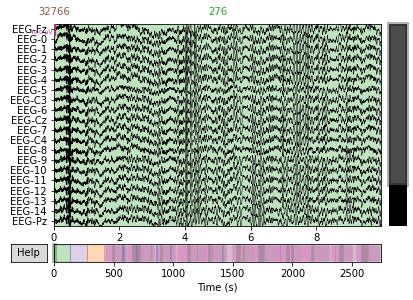

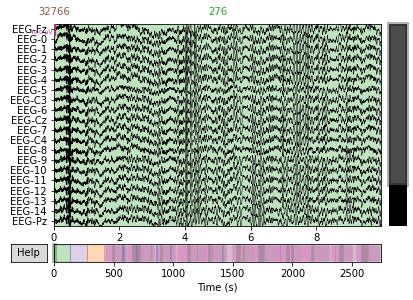

In [ ]:
rawDataGDF.plot()

In [ ]:
# import os
# import numpy as np
# import scipy.io
# from scipy.io import loadmat
# import matplotlib.pyplot as plt
# import mne
# %pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
dataset